# Projet Deep Learning

In [1]:
# IMPORTATION des modules

from google.colab import files
import io

import os
import pandas as pd
import numpy as np
import pydot

import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers as L
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import plot_model

import random

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import seaborn as sns

from IPython.display import display, HTML

In [2]:
# Files : train.json, test.json, outputraw1587 (weight), vienna_train(Vienna RNA), vienna_test(Vienna RNA) & sample_submission.csv

uploaded = files.upload()

Saving outputraw1587.txt.clstr to outputraw1587.txt (2).clstr
Saving sample_submission.csv to sample_submission (1).csv
Saving test.json to test (2).json
Saving train.json to train (2).json
Saving vienna_test.txt to vienna_test (1).txt
Saving vienna_train.txt to vienna_train (1).txt


In [3]:
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']
input_cols = ['sequence', 'structure', 'predicted_loop_type']

In [24]:
train = pd.read_json(io.BytesIO(uploaded['train.json']), lines=True).drop('index', axis=1)
test = pd.read_json(io.BytesIO(uploaded['test.json']), lines=True).drop('index', axis=1)
sample_sub = pd.read_csv(io.BytesIO(uploaded['sample_submission.csv']))

In [39]:
# sélection des séquences avec un signal > 1 (minimisation du bruit de fond)
train = train.query("signal_to_noise >= 1")
train = train.query("SN_filter == 1")
train.shape

(1587, 18)

## Exploration et représentation des données

In [6]:
# traitement du dataframe
train.columns
df = train[['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C','reactivity_error',
       'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C',
       'deg_error_50C']]
df = df.rename(columns = {'reactivity_error' : 'error_reactivity','deg_error_Mg_pH10':'error_deg_Mg_pH10',
                          'deg_error_pH10':'error_deg_pH10','deg_error_Mg_50C':'error_deg_Mg_50C',
                      'deg_error_50C':'error_deg_50C'})
df = df.melt(var_name='variables',value_name='values')

In [7]:
errors = []
for i in range(df.shape[0]):
  if 'error' in df.iloc[i,0]:
    df.iloc[i,0] = df.iloc[i,0][df.iloc[i,0].index('error')+6:]
    errors.append('error')
  else :
    errors.append('mesured')
  somme = 0
  lenval = list(df.iloc[i])[1]
  for j in range(len(lenval)):
    somme +=lenval[j]
  df.iloc[i,1] = (somme/len(lenval))

df.iloc[:,1] = df.iloc[:,1].astype(np.float64)
df['group'] = errors

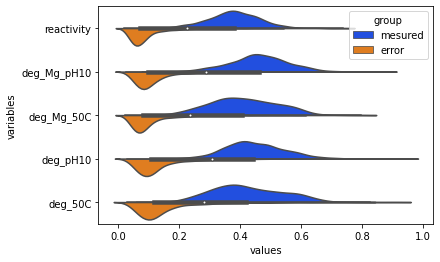

In [8]:
ax = sns.violinplot(y='variables',x='values',data=df,hue='group',split = True,palette="bright",scale="width")

In [9]:
def extract(name,data):
  mydict = {}
  indexcolname = list(train.columns).index(name)
  for i,s in enumerate(data[name]):
    for pos in range(68): #91 if change to test
      if data.iloc[i,3][pos] not in mydict:
        mydict[data.iloc[i,3][pos]] = []
      mydict[data.iloc[i,3][pos]].append(data.iloc[i,indexcolname][pos])
  return mydict  

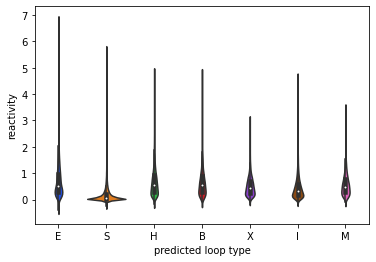

In [10]:
name = pred_cols[0]
dt_reactivity = extract(name,train)
data_reac = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dt_reactivity.items() ]))
dr = data_reac.melt(var_name='predicted loop type',value_name=name)
ax = sns.violinplot(x='predicted loop type',y=name,data=dr,palette="bright")

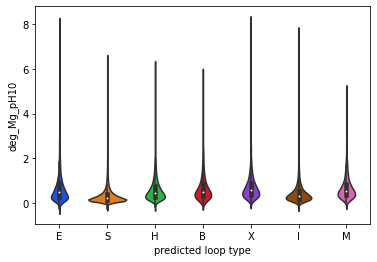

In [11]:
name = pred_cols[1]
dt_reactivity = extract(name,train)
data_reac = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dt_reactivity.items() ]))
dr = data_reac.melt(var_name='predicted loop type',value_name=name)
ax = sns.violinplot(x='predicted loop type',y=name,data=dr,palette="bright")

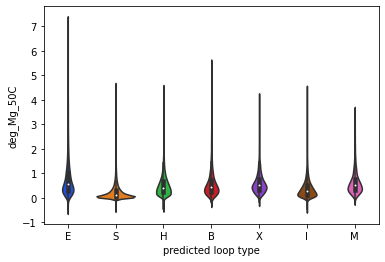

In [12]:
name = pred_cols[2]
dt_reactivity = extract(name,train)
data_reac = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dt_reactivity.items() ]))
dr = data_reac.melt(var_name='predicted loop type',value_name=name)
ax = sns.violinplot(x='predicted loop type',y=name,data=dr,palette="bright")

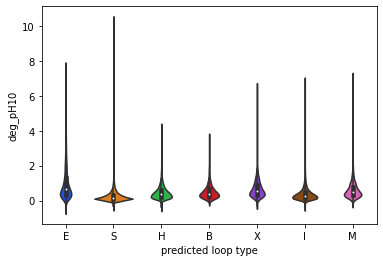

In [13]:
name = pred_cols[3]
dt_reactivity = extract(name,train)
data_reac = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dt_reactivity.items() ]))
dr = data_reac.melt(var_name='predicted loop type',value_name=name)
ax = sns.violinplot(x='predicted loop type',y=name,data=dr,palette="bright")

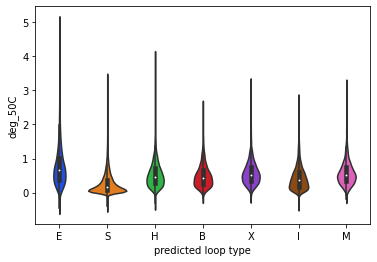

In [14]:
name = pred_cols[4]
dt_reactivity = extract(name,train)
data_reac = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dt_reactivity.items() ]))
dr = data_reac.melt(var_name='predicted loop type',value_name=name)
ax = sns.violinplot(x='predicted loop type',y=name,data=dr,palette="bright")

## Clusterisation des séquences

In [40]:
def extract_clusters(clstr_file):
    """Extract clusters from .clstr file and return a dict 
    with keys = clusters and dict[key] = [clustersize,[sequences]]
    """
    with open(clstr_file,'r') as file:
        cluster = {}
        sequences = []
        clusternum = 1
        entiers = ["0","1","2","3","4","5","6","7","8","9"]
        clustsize = 0
        rmb = 0
        for line in file:
            if line[0] != '>':
                rmb += 1
                if rmb > 9:
                    clustsize = int(line[0:2]) + 1
                    seq = line[14:18]
                else:
                    clustsize = int(line[0]) + 1
                    seq = line[13:17]
                for i,let in enumerate(seq):
                    if let not in entiers:
                        seq = seq[0:i]
                        break
                sequences.append(seq)
            else :
                if clustsize >= 0:
                    cluster[clusternum] = [clustsize,sequences]
                    clusternum += 1
                sequences = []
                rmb = 0
    return cluster

def construct_weight(clustering,dim_vector):
    """
    Construct the weight vector from a dict
    """
    weights = list(range(dim_vector))
    for key in clustering.keys():
        if key == 0:
            continue
        for numseq in clustering[key][1]:
            weights[int(numseq)-1] = float(1/clustering[key][0])
    return weights

In [41]:
clustering = extract_clusters('outputraw1587.txt.clstr') 
weights = construct_weight(clustering, train.shape[0])

## Apprentissage

In [42]:
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']
input_cols = ['sequence', 'structure', 'predicted_loop_type']

In [43]:
def preprocess_inputs(df,input_cols):
    """
    Converts inputs into one-hot
    """
    output = []
    for i in range(len(input_cols)):
        tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
        tokenizer.fit_on_texts(np.asarray(df[input_cols[i]]))
        tmp = tokenizer.texts_to_sequences(np.asarray(df[input_cols[i]]))
        new_var = np.asarray(keras.utils.to_categorical(tmp)[:,:,1:])
        if new_var.shape[1] != 130:
            longer = np.full((new_var.shape[0], 130, new_var.shape[2]), np.float32(0))
            for seq_index in range(len(new_var)):
                tmp = new_var[seq_index]
                row_len = len(tmp[0])
                new_line = np.full(row_len, -10, np.float32)
                while len(tmp) != 130:
                    tmp = np.vstack((tmp, new_line))
                longer[seq_index] = tmp
            output.append(longer)
        else:
            output.append(new_var)
    return output

In [44]:
def merge_inputs(inputs):
    """
    Merges the one-hot inputs by columns
    transform in numpy array
    """
    size = len(inputs[0])
    output = []
    for i in range(size):
        output.append(np.concatenate((inputs[0][i], inputs[1][i], inputs[2][i]), axis = 1))
    return np.asarray(output)

In [45]:
def preprocess_results(df, results, train = True):
    """
    Makes sure that the results are in the appropriate format:
        [layers,lines,columns] in an np array
    """
    tmp = np.asarray(df[results])
    size = len(tmp[0])
    output = np.zeros((len(tmp),len(tmp[0][0]),len(results)))
    for i in range(len(results)):
        for j in range(size):
            tmp[i,j] = np.asarray(tmp[i,j])
    for i in range(len(tmp)):
        output[i] = np.vstack((tmp[i,0], tmp[i,1], tmp[i,2], tmp[i,3], tmp[i, 4]))[:,:].T
    return output

In [46]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(0, 1))
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1)

In [47]:
# Submission private/public test
test_private = test[test.seq_length == 130]
test_public = test[test.seq_length == 107]

# Encoding
inputs_public_array = merge_inputs(preprocess_inputs(test_public, input_cols))
inputs_private_array = merge_inputs(preprocess_inputs(test_private, input_cols))

In [85]:
def submission_into_csv(public_predicted, private_predicted, test_public, test_private,
                        columns = pred_cols, sheet_csv = sample_sub) :
    ''' fonction pour soumettre les résultats dans le fichier csv Kaggle
    arguments :
        - test_public & test_private = df
        - public_predicted & test_predicted = model trained
      returns df
    '''
    
    preds_gru = []

    for df, preds in [(test_public, public_full_predicted), (test_private, private_full_predicted)]:
        for i, uid in enumerate(df.id):
            single_pred = preds[i]

            single_df = pd.DataFrame(single_pred, columns=columns)
            single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

            preds_gru.append(single_df)

    preds_gru_df = pd.concat(preds_gru)
    submission = sheet_csv[['id_seqpos']].merge(preds_gru_df, on=['id_seqpos'])
    return submission


In [49]:
# one hot encoding
inputs_ohe = preprocess_inputs(train, input_cols)
inputs_array = merge_inputs(inputs_ohe)
print(inputs_array.shape)

(1587, 130, 14)


In [50]:
expected_results = preprocess_results(train, pred_cols)
expected_results.shape

(1587, 68, 5)

In [51]:
#### MODEL GRU Bidirectionnal ####

def build_gru(output_length, lr=0.001, input_shape = (130,14), 
              space_dropout = 0.2, 
              masking_val = np.float32(-10)) :
    
    opt = tf.keras.optimizers.Adam(learning_rate = lr)

    inputs = L.Input(shape = input_shape)
    mask   = L.Masking(mask_value=np.float32(masking_val))(inputs)
    mask   = L.SpatialDropout1D(space_dropout)(mask)
    
    x1 = L.Bidirectional(L.GRU(units = 300, dropout = 0.2, return_sequences = True))(mask)
    x2 = L.Bidirectional(L.GRU(units = 150, dropout = 0.2, return_sequences = True))(x1)
    x3 = L.Bidirectional(L.GRU(units = 70,  dropout = 0.2, return_sequences = True))(x2)
    
    # cut masking values
    sliced_layer = x3[:, :output_length]
    out_layer = L.Dense(5, activation = 'linear')(sliced_layer)
    
    model_gru = tf.keras.Model(inputs = inputs, outputs = out_layer)
    model_gru.compile(optimizer = opt, loss = 'mse', metrics = [MCRMSE])
    
    return model_gru

In [52]:
model_gru = build_gru(output_length = 68)
model_gru.summary()

callback = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10), 
            tf.keras.callbacks.ModelCheckpoint('trained.h5'),
            tf.keras.callbacks.ReduceLROnPlateau(patience=5)]

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 130, 14)]         0         
_________________________________________________________________
masking_5 (Masking)          (None, 130, 14)           0         
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 130, 14)           0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 130, 600)          568800    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 130, 300)          676800    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 130, 140)          156240    
_________________________________________________________________
tf_op_layer_strided_slice_5  [(None, 68, 140)]       

In [53]:
#================= TRAINING w/o weight ================
            
history_training = model_gru.fit(
    inputs_array, expected_results,
    batch_size=64,
    epochs=500,
    validation_split = 0.2,
    callbacks = callback,
    shuffle = True,
    verbose=1)

Epoch 1/500
20/20 [==============================] - 7s 369ms/step - loss: 0.2251 - MCRMSE: 0.4677 - val_loss: 0.1642 - val_MCRMSE: 0.4025
Epoch 2/500
20/20 [==============================] - 2s 118ms/step - loss: 0.1707 - MCRMSE: 0.4106 - val_loss: 0.1453 - val_MCRMSE: 0.3790
Epoch 3/500
20/20 [==============================] - 2s 118ms/step - loss: 0.1557 - MCRMSE: 0.3923 - val_loss: 0.1399 - val_MCRMSE: 0.3719
Epoch 4/500
20/20 [==============================] - 2s 118ms/step - loss: 0.1476 - MCRMSE: 0.3823 - val_loss: 0.1325 - val_MCRMSE: 0.3620
Epoch 5/500
20/20 [==============================] - 2s 118ms/step - loss: 0.1401 - MCRMSE: 0.3723 - val_loss: 0.1245 - val_MCRMSE: 0.3516
Epoch 6/500
20/20 [==============================] - 2s 118ms/step - loss: 0.1337 - MCRMSE: 0.3641 - val_loss: 0.1171 - val_MCRMSE: 0.3409
Epoch 7/500
20/20 [==============================] - 2s 118ms/step - loss: 0.1275 - MCRMSE: 0.3554 - val_loss: 0.1143 - val_MCRMSE: 0.3370
Epoch 8/500
20/20 [========

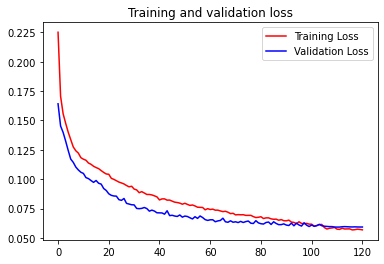

In [54]:
loss = history_training.history['loss']
val_loss = history_training.history['val_loss']
epochs = range(len(loss))
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [33]:
#Creation of function that gives train and test set indexes from a pandas dataframe
def data_sep(dataset, data_size, train_size):
    train = random.sample(range(data_size), train_size)
    test = list(range(0,data_size))
    for i in train:
        test.remove(i)
    return(train,test)

In [ ]:
#========== KFold Cross-validation ================

inputs = inputs_array
targets = expected_results

num_folds = 5
fold_no = 1

while fold_no <= num_folds:
    kf_train_index, kf_test_index = data_sep(train,1587,1300)
    train_in = inputs[kf_train_index, ]
    test_in = inputs[kf_test_index, ]
    train_out = targets[kf_train_index, ]
    test_out = targets[kf_test_index, ]

    kf_model = build_gru(output_length = 68)
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    history = kf_model.fit(train_in, train_out, batch_size=100, epochs=30, verbose=0)
    
  
    # Generate generalization metrics
    scores = kf_model.evaluate(test_in, test_out, verbose=0)
    print(f'Score for fold {fold_no}: {kf_model.metrics_names[0]} of {scores[0]}\n\
    and {kf_model.metrics_names[1]} of {scores[1]}')
    fold_no+=1

In [71]:
# on utilise les poids du modèle run précédemment
model_train_pred = build_gru(107)
model_train_pred.load_weights('trained.h5')

model_public = build_gru(107)
model_public.load_weights('trained.h5')

model_private = build_gru(130)
model_private.load_weights('trained.h5')

train_full_predicted = model_train_pred.predict(inputs_array)
public_full_predicted = model_public.predict(inputs_public_array)
private_full_predicted = model_private.predict(inputs_private_array)

In [74]:
# soumission des prédictions dans le tableau csv Kaggle

submission_model = submission_into_csv(test_public = test_public, 
                               public_predicted = public_full_predicted, 
                               test_private = test_private,
                               private_predicted = private_full_predicted)

submission_model.to_csv('submission_model.csv', index=False)
files.download('submission_model.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
submission_model.head(4)

,id_seqpos,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C
0,id_00073f8be_0,0.933570,0.838849,0.694158,2.026716,0.828195
1,id_00073f8be_1,3.366122,4.053998,3.928263,5.167129,3.298460
2,id_00073f8be_2,1.673312,0.921580,0.863051,0.675904,0.748903
3,id_00073f8be_3,1.459746,1.479767,1.952469,1.466259,1.703115


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



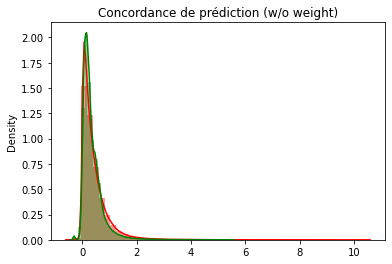

In [57]:
# valeurs prédites (train) sur les valeurs attendues

import seaborn as sns

sns.distplot(expected_results[:,:,:], color='red')
sns.distplot(private_full_predicted, color='green').set_title('Concordance de prédiction (w/o weight)')
plt.show()

In [59]:
#================= TRAINING with weight ================

model_weight = build_gru(output_length = 68)
callback = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10), 
            tf.keras.callbacks.ModelCheckpoint('trained_weight.h5'),
            tf.keras.callbacks.ReduceLROnPlateau(patience=5)]

In [60]:
history_weight = model_weight.fit(
    inputs_array, expected_results,
    batch_size=64,
    epochs=500,
    validation_split = 0.2,
    callbacks = callback,
    shuffle = True,
    verbose=0,
    sample_weight=np.array(weights)
)

In [ ]:
#Creation of function that gives train and test set indexes from a pandas dataframe
def data_sep(dataset, data_size, train_size):
    ''' 
    renvoie les index des échantillons test et train
    '''
    train = random.sample(range(data_size), train_size)
    test = list(range(0,data_size))
    for i in train:
        test.remove(i)
    return(train,test)

#========== KFold Cross-validation ================

inputs = inputs_array
targets = expected_results

num_folds = 3
fold_no = 1

while fold_no <= num_folds:
    kf_train_index, kf_test_index = data_sep(train,1587,1300)
    train_in = inputs[kf_train_index, ]
    test_in = inputs[kf_test_index, ]
    train_out = targets[kf_train_index, ]
    test_out = targets[kf_test_index, ]

    weight_model = build_gru(output_length = 68)
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    sample_weight=np.array(weights)[kf_train_index]
    history = weight_model.fit(train_in, train_out, batch_size=100, epochs=30, verbose=0, sample_weight=sample_weight)
    
  
    # Generate generalization metrics
    scores = weight_model.evaluate(test_in, test_out, verbose=0)
    print(f'Score for fold {fold_no}: {weight_model.metrics_names[0]} of {scores[0]}\n\
    and {weight_model.metrics_names[1]} of {scores[1]}')
    fold_no+=1

In [75]:
# on utilise les poids du modèle run précédemment
model_train_pred = build_gru(107)
model_train_pred.load_weights('trained_weight.h5')

model_public = build_gru(107)
model_public.load_weights('trained_weight.h5')

model_private = build_gru(130)
model_private.load_weights('trained_weight.h5')

train_full_predicted = model_train_pred.predict(inputs_array)
public_full_predicted = model_public.predict(inputs_public_array)
private_full_predicted = model_private.predict(inputs_private_array)

In [78]:
submission_model_weight = submission_into_csv(test_public = test_public, 
                                              test_private = test_private, 
                                              public_predicted = public_full_predicted, 
                                              private_predicted = private_full_predicted)
submission_model_weight.head(4)
submission_model_weight.to_csv('submission_weight.csv', index=False)
files.download('submission_weight.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
submission_model_weight.tail(4)

,id_seqpos,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C
457949,id_ffda94f24_126,0.540554,0.616535,0.653847,0.431096,0.726814
457950,id_ffda94f24_127,0.509221,0.513840,0.587240,0.183215,0.631684
457951,id_ffda94f24_128,0.289691,0.352725,0.379789,-0.040966,0.459543
457952,id_ffda94f24_129,0.076705,0.278284,0.189429,-0.213468,0.364433


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



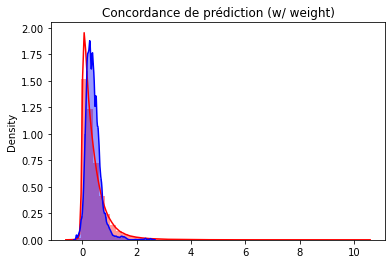

In [64]:
# valeurs prédites (train) sur les valeurs attendues

import seaborn as sns

sns.distplot(expected_results[:,:,:], color='red')
sns.distplot(private_full_predicted, color='blue').set_title('Concordance de prédiction (w/ weight)')

plt.show()

In [90]:
#=============================================================================================
# Evaluation de l'apprentissage avec prédiction de structure secondaire (files test seulement)
#=============================================================================================

# 100% concordance fichier train
# 49% concordance fichier test

test = pd.read_json(io.BytesIO(uploaded['test.json']), lines=True).drop('index', axis=1)
pred_ss_test = pd.read_table(io.BytesIO(uploaded['vienna_test.txt']), header=None)
test_df_vienna = test.copy()
# on remplace la colonne structure par les nouvelles prédictions avec viennaRNA
test_df_vienna['structure'] = pred_ss_test

In [99]:
model_vienna = build_gru(output_length = 68)

callback = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10), 
            tf.keras.callbacks.ModelCheckpoint('trained_vienna.h5'),
            tf.keras.callbacks.ReduceLROnPlateau(patience=5)]

history_vienna = model_vienna.fit(inputs_array, expected_results,batch_size=64,epochs=500,validation_split = 0.2,callbacks = callback,shuffle = True,verbose=1)

Epoch 1/500
20/20 [==============================] - 7s 373ms/step - loss: 0.2247 - MCRMSE: 0.4679 - val_loss: 0.1631 - val_MCRMSE: 0.4007
Epoch 2/500
20/20 [==============================] - 2s 119ms/step - loss: 0.1679 - MCRMSE: 0.4071 - val_loss: 0.1443 - val_MCRMSE: 0.3776
Epoch 3/500
20/20 [==============================] - 2s 119ms/step - loss: 0.1547 - MCRMSE: 0.3911 - val_loss: 0.1370 - val_MCRMSE: 0.3679
Epoch 4/500
20/20 [==============================] - 2s 118ms/step - loss: 0.1461 - MCRMSE: 0.3802 - val_loss: 0.1284 - val_MCRMSE: 0.3565
Epoch 5/500
20/20 [==============================] - 2s 119ms/step - loss: 0.1376 - MCRMSE: 0.3690 - val_loss: 0.1203 - val_MCRMSE: 0.3454
Epoch 6/500
20/20 [==============================] - 2s 118ms/step - loss: 0.1323 - MCRMSE: 0.3620 - val_loss: 0.1215 - val_MCRMSE: 0.3470
Epoch 7/500
20/20 [==============================] - 2s 119ms/step - loss: 0.1293 - MCRMSE: 0.3581 - val_loss: 0.1137 - val_MCRMSE: 0.3357
Epoch 8/500
20/20 [========

In [100]:
test_private_vienna = test_df_vienna[test_df_vienna.seq_length == 130]
test_public_vienna = test_df_vienna[test_df_vienna.seq_length == 107]

# traitement des data pour le réseau
inputs_public_vienna = merge_inputs(preprocess_inputs(test_public_vienna, input_cols))
inputs_private_vienna = merge_inputs(preprocess_inputs(test_private_vienna, input_cols))

In [101]:
# Evaluation fichier test

model_public_vienna = build_gru(107)
model_public_vienna.load_weights('trained_vienna.h5')

model_private_vienna = build_gru(130)
model_private_vienna.load_weights('trained_vienna.h5')

public_full_predicted_vienna = model_public_vienna.predict(inputs_public_vienna)
private_full_predicted_vienna = model_private_vienna.predict(inputs_private_vienna)

In [104]:
submission_model_vienna = submission_into_csv(test_public = test_public_vienna, 
                                              test_private = test_private_vienna, 
                                              public_predicted = public_full_predicted_vienna,
                                              private_predicted = private_full_predicted_vienna)
submission_model_vienna.head(4)
submission_model_vienna.to_csv('submission_vienna.csv', index=False)
files.download('submission_vienna.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [103]:
submission_model_vienna.head(4)

,id_seqpos,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C
0,id_00073f8be_0,0.715888,0.883645,0.848498,2.297472,0.942759
1,id_00073f8be_1,1.443379,1.595993,1.634332,2.561034,1.556827
2,id_00073f8be_2,1.457093,1.262169,1.583681,1.643831,1.441732
3,id_00073f8be_3,1.156774,0.958721,1.294116,1.069380,1.128269
